Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

In [0]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.0.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df0 = pd.read_csv('../data/renthop-nyc.csv')
assert df0.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df0[(df0['price'] >= np.percentile(df0['price'], 0.5)) & 
        (df0['price'] <= np.percentile(df0['price'], 99.5)) & 
        (df0['latitude'] >= np.percentile(df0['latitude'], 0.05)) & 
        (df0['latitude'] < np.percentile(df0['latitude'], 99.95)) &
        (df0['longitude'] >= np.percentile(df0['longitude'], 0.05)) & 
        (df0['longitude'] <= np.percentile(df0['longitude'], 99.95))]

In [5]:
# convert date to date time

df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# Creates a new features called total rooms
df['rooms']= df['bathrooms']+df['bedrooms'];

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
# creates a new feature called amenities
# yesterday I took every column from elevator onward, today I will handpick 
# the amenities I think may indicate a more expensive apartment

df['amenities']= ( 
    df['hardwood_floors'] + 
    df['doorman'] + 
    df['dining_room'] + 
    df['fitness_center'] +
    df['laundry_in_unit']
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [8]:
# Now I will create third adding total rooms to amenities called roomenities

df['roomenities'] =df['rooms']+df['amenities']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
# splits data into train and test based on dates given in assignment

dfTrain = df[(df['created'] > '2016-4-1 01:00:00') & (df['created'] <= '2016-6-1 00:00:00')]
dfTest = df[(df['created'] > '2016-6-1 01:00:00') & (df['created'] <= '2016-7-1 00:00:00')]

In [10]:
dfTrain.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,rooms,amenities,roomenities
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1,3.0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1,3.0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0,5.0
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,7995,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0,6.0
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,3600,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,3.0


NameError: ignored

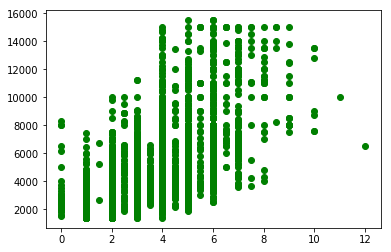

In [11]:
mod1 = LR()

feat1 = ['rooms']
targ1 = 'price'

X1 = dfTrain[feat1]
y1 = dfTrain[targ1]

mod1.fit(X1,y1)

y_pred1train = mod1.predict(X1)
y_pred1test = mod1.predict(dfTest[feat1])

plt.scatter(dfTest[feat1], dfTest[targ1], color= 'green') # actual test data
plt.plot(dfTest[feat1], y_pred1, color='red') # model predictions of test data
plt.xlabel('rooms')
plt.ylabel('price')
plt.title('Test Data')

plt.show()

In [0]:
print('Model Coefficient: ', mod1.coef_[0])
print('Model y-intercept: ', mod1.intercept_)

In [0]:
# Train errors

print('Train Mean Absolute Error: ', mean_absolute_error(y1,y_pred1train))
print('Train Root Mean Squared Error: ', mean_squared_error(y1,y_pred1train))
print('Train R squared error: ', r2_score(y1,y_pred1train))

print('')

# test errors 
print('Test Mean Absolute Error: ', mean_absolute_error(dfTest[feat1],y_pred1test))
print('Test Root Mean Squared Error: ', mean_squared_error(dfTest[feat1],y_pred1test))
print('Test R squared error: ', r2_score(dfTest[feat1],y_pred1test))

In [0]:
mean_absolute_error(dfTest[feat1],y_pred1)

In [0]:
mod2 = LR()

feat2 = ['amenities']
targ2 = 'price'

X2 = dfTrain[feat2]
y2 = dfTrain[targ2]

mod2.fit(X2,y2)

y_pred2train = mod2.predict(X2)
y_pred2test = mod2.predict(dfTest[feat2])

plt.scatter(dfTest[feat2], dfTest[targ2], color= 'green') # actual test data
plt.plot(dfTest[feat2], y_pred2, color='red') # model predictions of test data
plt.xlabel('amenities')
plt.ylabel('price')
plt.title('Test Data')

plt.show()

In [0]:
print('model coefficient: ', mod2.coef_[0])
print('model y-intercept: ', mod2.intercept_)

In [0]:
# Train errors

print('Train Mean Absolute Error: ', mean_absolute_error(y2,y_pred2train))
print('Train Root Mean Squared Error: ', mean_squared_error(y2,y_pred2train))
print('Train R squared error: ', r2_score(y2,y_pred2train))

print('')

# test errors 
print('Test Mean Absolute Error: ', mean_absolute_error(dfTest[feat2],y_pred2test))
print('Test Root Mean Squared Error: ', mean_squared_error(dfTest[feat2],y_pred2test))
print('Test R squared error: ', r2_score(dfTest[feat2],y_pred2test))

In [0]:
mod3 = LR()

feat3 = ['roomenities']
targ3 = 'price'

X3 = dfTrain[feat3]
y3 = dfTrain[targ3]

mod3.fit(X3,y3)

y_pred3train = mod3.predict(X3)
y_pred3test = mod3.predict(dfTest[feat3])

plt.scatter(dfTest[feat3], dfTest[targ3], color= 'green') # actual test data
plt.plot(dfTest[feat3], y_pred3, color='red') # model predictions of test data
plt.xlabel('roomenities')
plt.ylabel('price')
plt.title('Test Data')

plt.show()

In [0]:
print('model coefficient: ', mod3.coef_[0])
print('model y-intercept: ', mod3.intercept_)

In [0]:
# Train errors

print('Train Mean Absolute Error: ', mean_absolute_error(y3,y_pred3train))
print('Train Root Mean Squared Error: ', mean_squared_error(y3,y_pred3train))
print('Train R squared error: ', r2_score(y3,y_pred3train))

print('')

# test errors 
print('Test Mean Absolute Error: ', mean_absolute_error(dfTest[feat3],y_pred3test))
print('Test Root Mean Squared Error: ', mean_squared_error(dfTest[feat3],y_pred3test))
print('Test R squared error: ', r2_score(dfTest[feat3],y_pred3test))

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.3, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 301: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.
- [ ] Add your own stretch goal(s) !